# Health Insurance Cross Sell

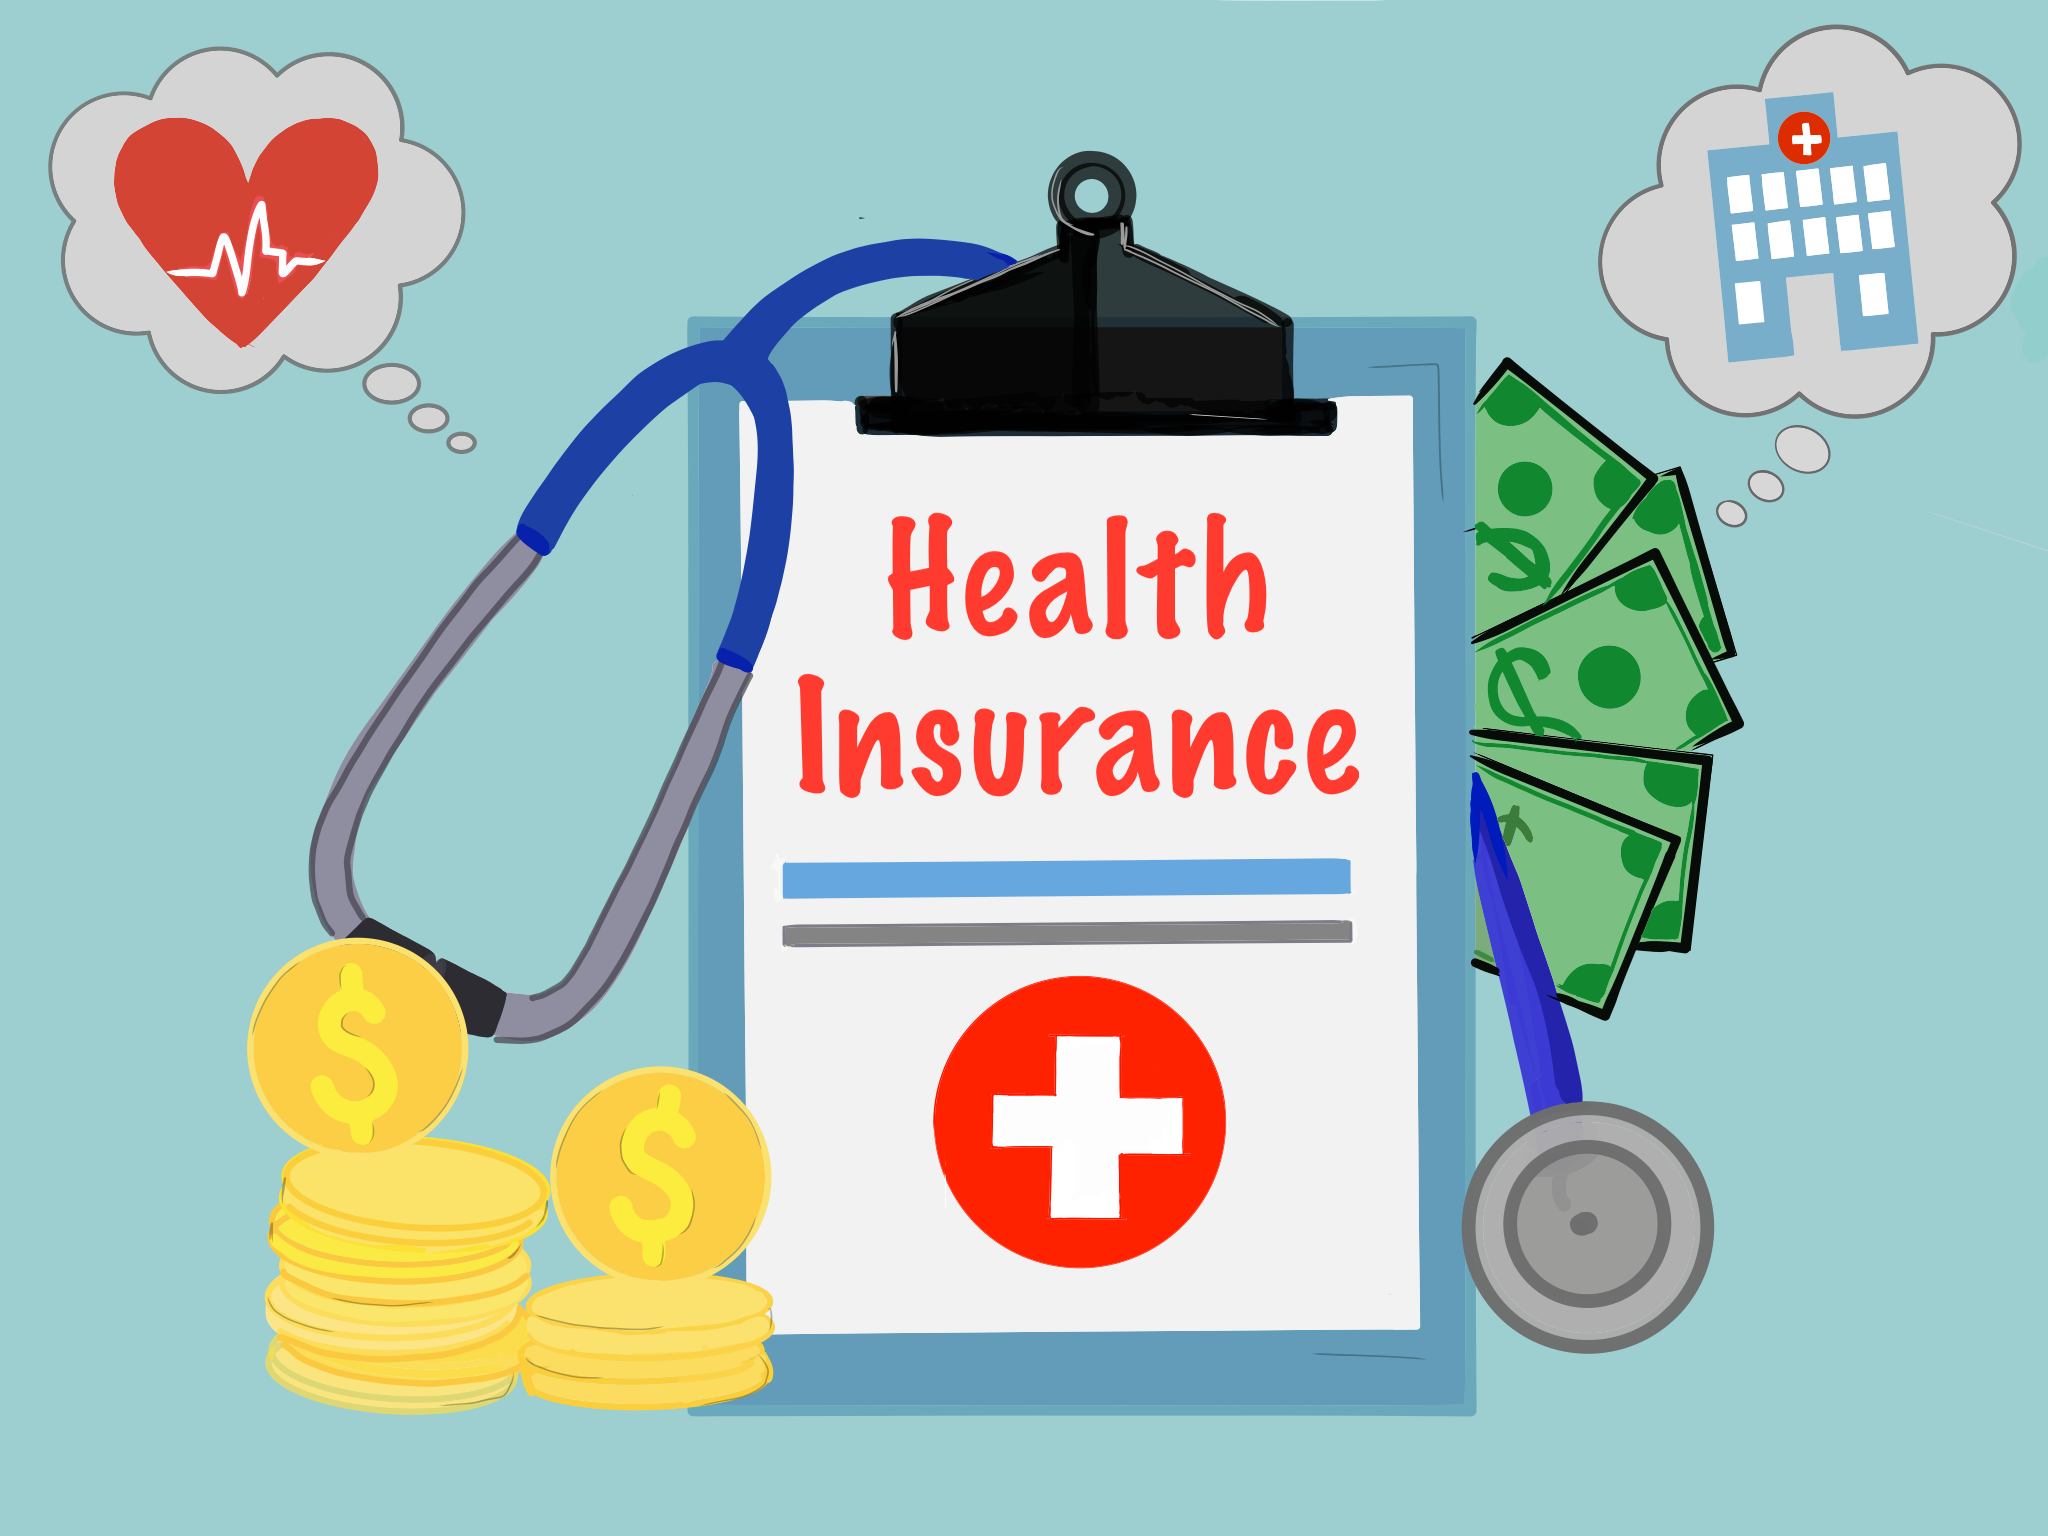

A Health Insurance company is analysing the possibility to offer their clients a new product: a car insurance. As well as the health insurance, the clients of this new product should pay annually to obtain a certain value assured by the company, for their cars. The company surveyed nearly 380,000 clients about the interest in joining a new car insurance product last year. All clients showed interest or not in purcharsing the new insurance product and these responses were saved in a database along with other client attributes. The product teams selected 127,000 new customers who did not respond to the survey to participate in a campaign, in which they will receive an offer of the new car insurance product. The offer will be made by the sales team through phone calls. However, the sales team has the capacity to make 20,000 calls within the campaign period.

**Table of contents**

* 1. [Business Problem](#business_problem)
    * 1.1. [Insurance Company Business](#insurance_company)
    * 1.2. [How to maximize profit?](#profit)
    * 1.3. [Increase number of purcharses per customer - Cross Sell](#cross_sell)
* 2. [Imports](#imports)
    * 2.1. [Helper Functions](#helper_functions)
* 3. [Data Extraction](#data_extraction)
    * 3.1. [Data Summary](#data_summary)
    * 3.2. [Schema Query](#schema_query)
    * 3.3. [Table query](#table_query)
    * 3.4. [Collect Data using Psycopg2](#data_psyco)
    * 3.5. [Collect Data using Pandas](#data_pandas)
* 4. [Data Description](#data_description)
    * 4.1. [Data Dimensions](#data_dimensions)
    * 4.2. [Data Types](#data_types)
    * 4.3. [Check Missing Values](#missing_values)
    * 4.4. [Descriptive Statistical](#descriptive_statistical)
        * 4.4.1. [Numerical Attributes](#numerical_attributes)
        * 4.4.2. [Categorical Attributes](#categorical_attributes)
* 5. [Feature Engineering](#feature_engineering)
* 6. [Exploratory Data Analysis](#eda)
    * 6.1. [Univariate Analysis](#univariate_analysis)
        * 6.1.1. [Response Variable](#response_variable)
        * 6.1.2. [Numerical Features](#numerical_features)
    * 6.2. [Bivariate Analysis](#bivariate_analysis)
        * 6.2.1. [Age](#age)
        * 6.2.2. [Annual Premium](#annual_premium)
        * 6.2.3. [Driving License](#driving_license)

# 1. Business Problem<a id='business_problem'></a>

* **What is the context like?**

    * A Health Insure company is evaluating the possibility to offer their clients a new car insurance product.

* **What is the root cause of the problem?**

    * The sales team needs to make calls to offer clients the new product, but they can make only 20,000 calls during the campaign.

* **Who is the Stakeholder of the problem?**

    * The company's CEO.

* **How will the solution be?**

    * Elaborate a model to predict if a client is interested or not on the new product to prioritize clients with higher chances to purcharse it.

    * Questions to be answered:

        1. Main insights about the most relevant client's attributes interested in purcharsing the car insurance.
        2. What percentage of clients interested in purcharsing car insurance will the sales team be able to contact by making 20,000 calls?
        3. And if the sales teams capacity increases to 40,000 calls, what percentage of customers interested in purcharsing car insurance will the sales team be able to contact?
        4. How many calls does the sales team need to make to contact 80% of customers interested in purcharsing car insurance?

## 1.1. Insurance Company Business<a id='insurance_company'></a>

**Profits based on probability of event ocurrency. In the case of the Health Insurance, the company's profit is calculated from the difference between the total annuity paid by the customers and the cost that the company ensured to those who got sick.**

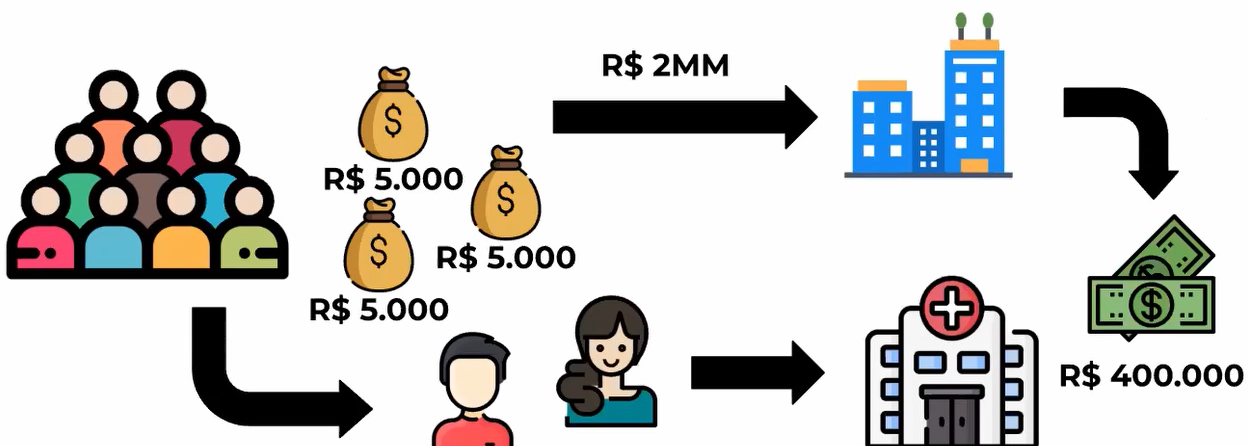

## 1.2. How to maximize profit?<a id='profit'></a>

The profit is ruled by the following equation:

$Profit=Revenue-Cost$

So, for maximizing profit one should maximize the revenue or minimize the costs. For each possibility we can think about some approaches:

1. Revenue:
    * Sales amount
    * Ticket (price paid by customer)
    * $Revenue = Ticket*Sales\_Amount$
    
2. Ticket:
    * Increase ticket

3. Sales Amount
    * Increase number of customers
    * Increase number of purcharses per customer
        * Increase product offer
        
4. Cost
    * Decrease operation cost
    * Decrease customer aquisition cost
    * Decrease product cost

## 1.3. Increase number of purcharses per customer - Cross Sell<a id='cross_sell'></a>

**Services or products' sales strategy to offer additional ones based on customer's interest.**

* Which clients should receive the cross-sell offer?
* Restrictions:
    * Cost reduction
    * Capacity limit

**Map clients by their purcharse probability**

# 2. Imports<a id='imports'></a>

In [103]:
from credentials import credentials
import pickle

import psycopg2 as pg
import pandas.io.sql as pqsl

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression

from IPython.core.display import HTML

## 2.1. Helper Functions<a id='helper_functions'></a>

In [104]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 7]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.max_columns', None)
    
    sns.set()

In [105]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


D:\Anaconda\envs\health\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['record', 'indices', 'std', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 3. Data Extraction<a id='data_extraction'></a>

## 3.1. Data Summary<a id='data_summary'></a>

* **Id**: customer's unique identifier.
* **Gender**: customer gender.
* **Age**: customer's age.
* **Driving License**: 0, the customer is not allowed to drive and 1, the customer is allowed to drive (CNH – National Driver's License)
* **Region Code**: customer's region code.
* **Previously Insured**: 0, customer does not have car insurance and 1, customer already has car insurance.
* **Vehicle Age**: age of the vehicle.
* **Vehicle Damage**: 0, customer has never had their vehicle damaged in the past and 1, customer has had their vehicle damaged in the past.
* **Annual Premium**: amount the customer paid the company for annual health insurance.
* **Policy sales channel**: anonymous code for the customer contact channel.
* **Vintage**: number of days the customer joined the company by purchasing health insurance.
* **Response**: 0, the customer is not interested and 1, the customer is interested.

## 3.2. Schema Query -> pa004<a id='schema_query'></a>

In [106]:
#engine to databse
conn = pg.connect(host = credentials.host,
           database = credentials.database,
           port = credentials.port, 
           user = credentials.user,
           password = credentials.password)

In [107]:
#create cursor
cur = conn.cursor()

# query
query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace

"""

# execute query
cur.execute(query_schema)

# return query results
record = cur.fetchall()
print(record)

#close cursor
cur.close()

[('pg_toast',), ('pg_temp_1',), ('pg_toast_temp_1',), ('pg_catalog',), ('information_schema',), ('public',), ('pa004',), ('pg_temp_4',), ('pg_toast_temp_4',), ('pa005',), ('pg_temp_9',), ('pg_toast_temp_9',)]


## 3.3. Table Query<a id='table_query'></a>

In [108]:
#create cursor
cursor = conn.cursor()

query_tables = """
    SELECT tablename
    FROM pg_tables
    WHERE schemaname = 'pa004'
"""

# execute query
cursor.execute(query_schema)

# return query results
record = cursor.fetchall()
print(record)

#close cursor
cursor.close()

[('pg_toast',), ('pg_temp_1',), ('pg_toast_temp_1',), ('pg_catalog',), ('information_schema',), ('public',), ('pa004',), ('pg_temp_4',), ('pg_toast_temp_4',), ('pa005',), ('pg_temp_9',), ('pg_toast_temp_9',)]


## 3.4. Collect Data using Psycopg2<a id='data_psyco'></a>

In [109]:
#create cursor
cursor = conn.cursor()

# query
query_tables_users = """
    SELECT *
    FROM pa004.users u
    WHERE u.age > 44
    LIMIT 10
"""

# execute query
cursor.execute(query_tables_users)

#  return query results
record = cursor.fetchall()
print(record)

# close cursor
cursor.close()

[(2, 'Male', 76, 3.0, 26.0), (3, 'Male', 47, 28.0, 26.0), (8, 'Female', 56, 28.0, 26.0), (11, 'Female', 47, 35.0, 124.0), (14, 'Male', 76, 28.0, 13.0), (15, 'Male', 71, 28.0, 30.0), (20, 'Female', 60, 33.0, 124.0), (21, 'Male', 65, 28.0, 124.0), (22, 'Male', 49, 28.0, 124.0), (27, 'Female', 51, 28.0, 124.0)]


In [110]:
# convert tuples to dataframe
data = pd.DataFrame(record)
data.head()

,0,1,2,3,4
0,2,Male,76,3.0,26.0
1,3,Male,47,28.0,26.0
2,8,Female,56,28.0,26.0
3,11,Female,47,35.0,124.0
4,14,Male,76,28.0,13.0


## 3.5. Collect Data using Pandas<a id='data_pandas'></a>

In [111]:
# query
query_tables_users = """
    SELECT *
    FROM pa004.users
    LIMIT 10
"""

df1 = pd.read_sql(query_tables_users, conn)
df1.head()

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0


In [112]:
# query
query_tables_users = """
    SELECT *
    FROM pa004.vehicle
    LIMIT 10
"""

df2 = pd.read_sql(query_tables_users, conn)
df2.head()

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No


In [113]:
# query
query_tables_users = """
    SELECT *
    FROM pa004.insurance
    LIMIT 10
"""

df3 = pd.read_sql(query_tables_users, conn)
df3.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0


In [114]:
# query
query_tables_users = """
    SELECT *
    FROM pa004.users u
    LEFT JOIN pa004.vehicle v ON (u.id = v.id)
    LEFT JOIN pa004.insurance i ON (u.id = i.id)
"""

df_raw = pd.read_sql(query_tables_users, conn)
df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


In [115]:
# close connection
conn.close()

In [116]:
# save dataframe as csv
df_raw.to_csv('./data/df_raw.csv', index = False)

# 4. Data Description<a id='data_description'></a>

In [117]:
df4 = pd.read_csv('./data/df_raw.csv')
df4.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## 4.1. Data Dimensions<a id='data_dimensions'></a>

In [118]:
print("Number of rows: {}".format(df4.shape[0]))
print("Number of Columns: {}".format(df4.shape[1]))

Number of rows: 381109
Number of Columns: 12


## 4.2. Data Types<a id='data_types'></a>

In [119]:
df4.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 4.3. Check Missing Values<a id='missing_values'></a>

In [120]:
df4.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 4.4. Descriptive Statistical<a id='descriptive_statistical'></a>

### 4.4.1. Numerical Attributes<a id='numerical_attributes'></a>

In [121]:
num_attributes = df4.select_dtypes(include = ["int64","float64"])

In [122]:
#mean median
ct1 = pd.DataFrame(num_attributes.apply(lambda x: x.mean())).T
ct2 = pd.DataFrame(num_attributes.apply(lambda x: x.median())).T

#Dispersion - Std, Min, Max, Range, Skew, Kurtosis

d1 = pd.DataFrame(num_attributes.apply(lambda x: x.std())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.min())).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max())).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.836208,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511611,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229888,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203995,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046110,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.155057,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671304,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327936,2.301906e+00,3.298788


### 4.4.2. Categorical Attributes<a id='categorical_attributes'></a>

In [123]:
cat_attributes = df4[["gender","vehicle_age","response","vehicle_damage","previously_insured"]]

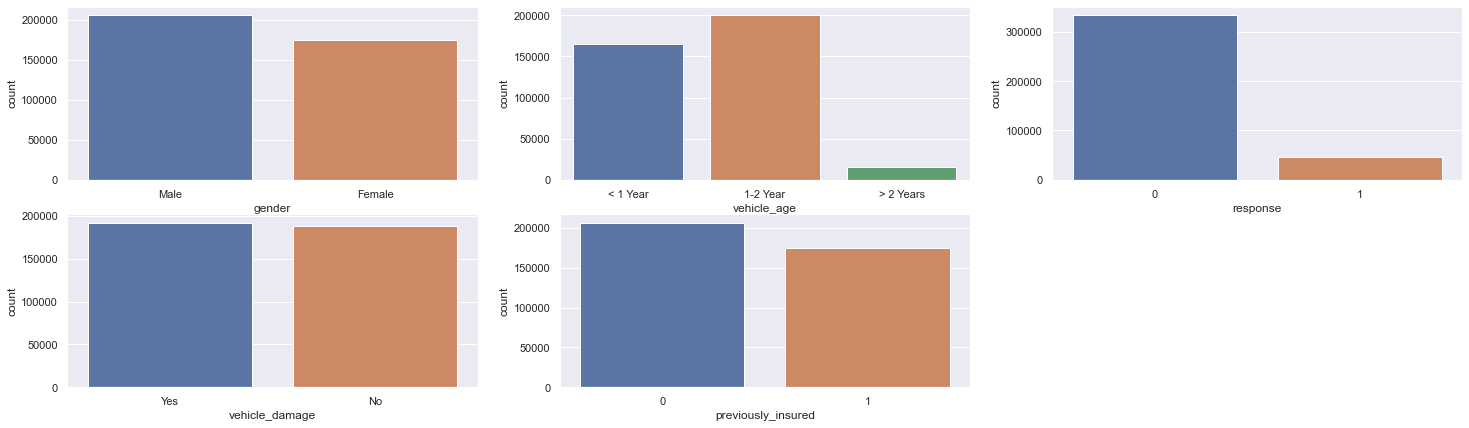

In [124]:
_ = plt.subplot(2,3,1)
_ = sns.countplot(x = "gender", data = cat_attributes)

_ = plt.subplot(2,3,2)
_ = sns.countplot(x = "vehicle_age", data = cat_attributes)

_ = plt.subplot(2,3,3)
_ = sns.countplot(x = "response", data = cat_attributes)

_ = plt.subplot(2,3,4)
_ = sns.countplot(x = "vehicle_damage", data = cat_attributes)

_ = plt.subplot(2,3,5)
_ = sns.countplot(x = "previously_insured", data = cat_attributes)

# 5. Feature Engineering<a id='feature_engineering'></a>

In [125]:
df5 = df4.copy()

In [126]:
#vehicle_age
df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x:'over_2_years' if x == "> 2 Years" 
                                              else 'between_1_2_year' if x == '1-2 Year'
                                              else 'below_1_year')


#vehicle_damage
df5['vehicle_damage'] = df5['vehicle_damage'].apply(lambda x: 1 if x == "Yes" else 0)

In [127]:
df5.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,below_1_year,1,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,between_1_2_year,0,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,below_1_year,0,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,below_1_year,0,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,between_1_2_year,1,0,42297.0,264,0


# 6. Exploratory Data Analysis<a id='eda'></a>

In [128]:
df6 = df5.copy()

## 6.1. Univariate Analysis<a id='univariate_analysis'></a>

### 6.1.1. Response Variable<a id='response_variable'></a>

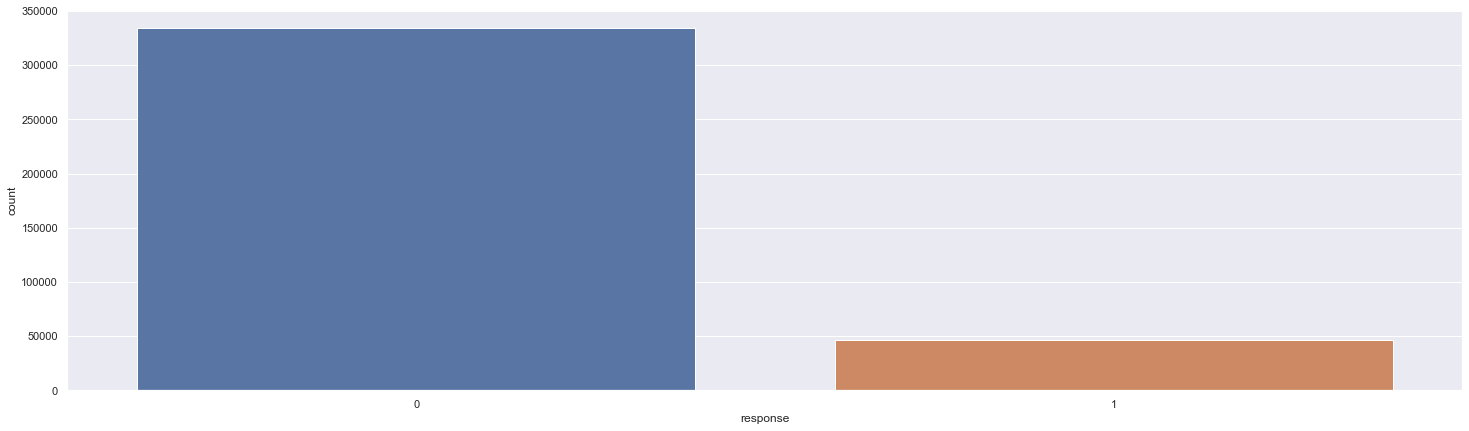

In [129]:
#reponse variable
sns.countplot(x = 'response', data = df6);

### 6.1.2. Numerical Features<a id='numerical_features'></a>

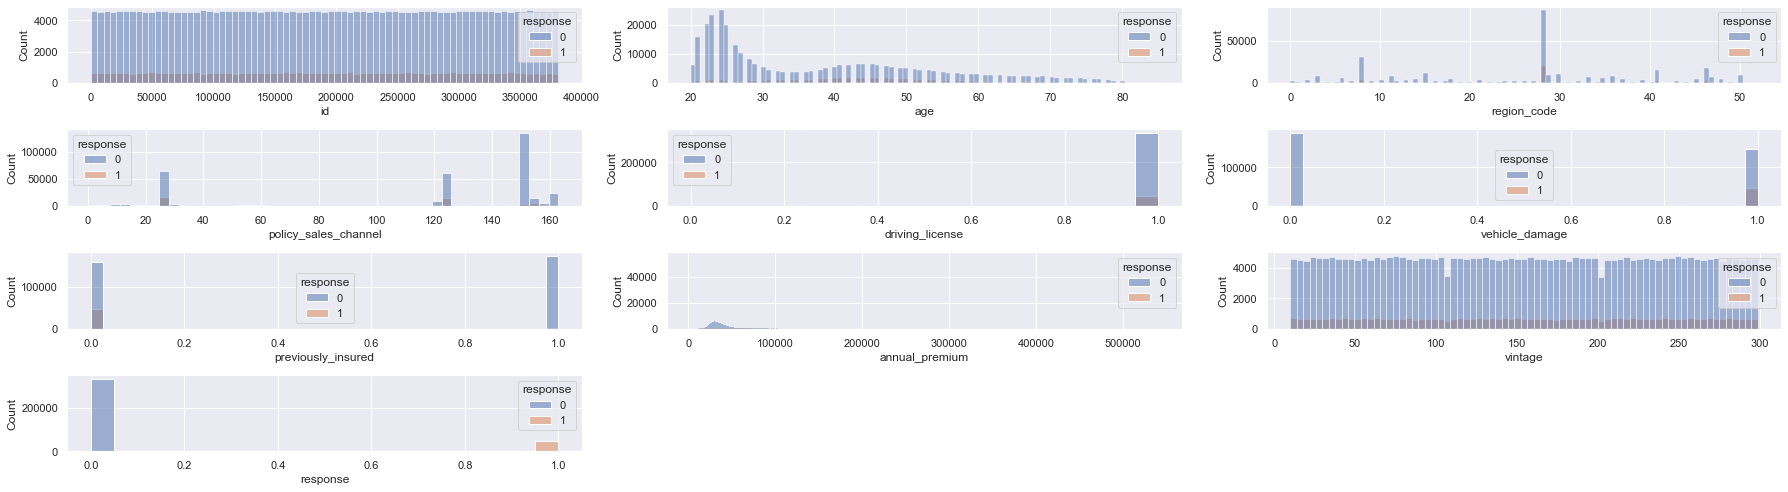

In [130]:
#plot histogram for each numerical attribute
num_attributes = df6.select_dtypes(include = ['int64','float64'])
columns = num_attributes.columns.to_list()

for i, column in enumerate(columns, 1):
    plt.subplot(4,3,i);
    sns.histplot(x = column, data = df6, hue = 'response');
plt.tight_layout();

## 6.2. Bivariate Analysis<a id='bivariate_analysis'></a>

### 6.2.1. Age<a id='age'></a>

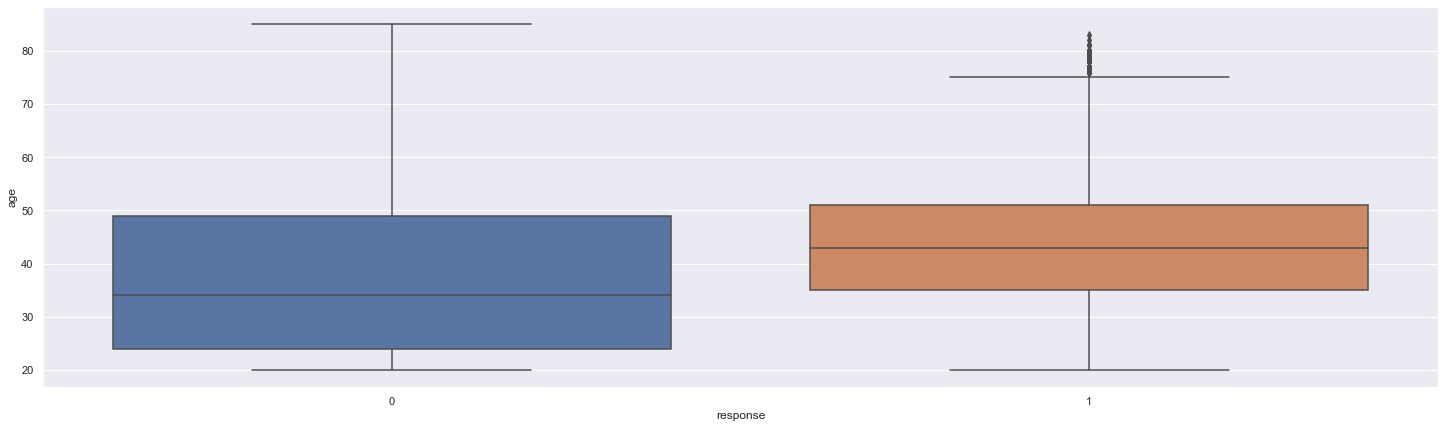

In [131]:
# age
sns.boxplot(x = 'response', y = 'age', data = df6);

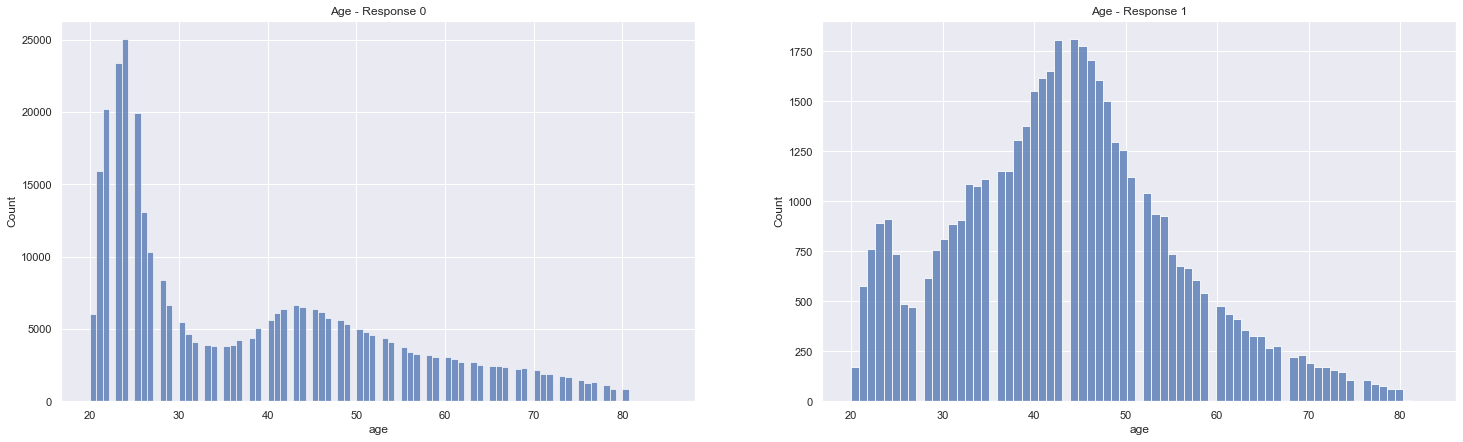

In [132]:
# age histogram
fig, axes = plt.subplots(1,2)

aux1 = df6.loc[df6['response'] == 0, 'age']
aux2 = df6.loc[df6['response'] == 1, 'age']

sns.histplot(aux1, ax = axes.ravel()[0]);
sns.histplot(aux2, ax = axes.ravel()[1]);

axes.ravel()[0].set_title('Age - Response 0');
axes.ravel()[1].set_title('Age - Response 1');

### 6.2.2. Annual Premium<a id='annual_premium'></a>

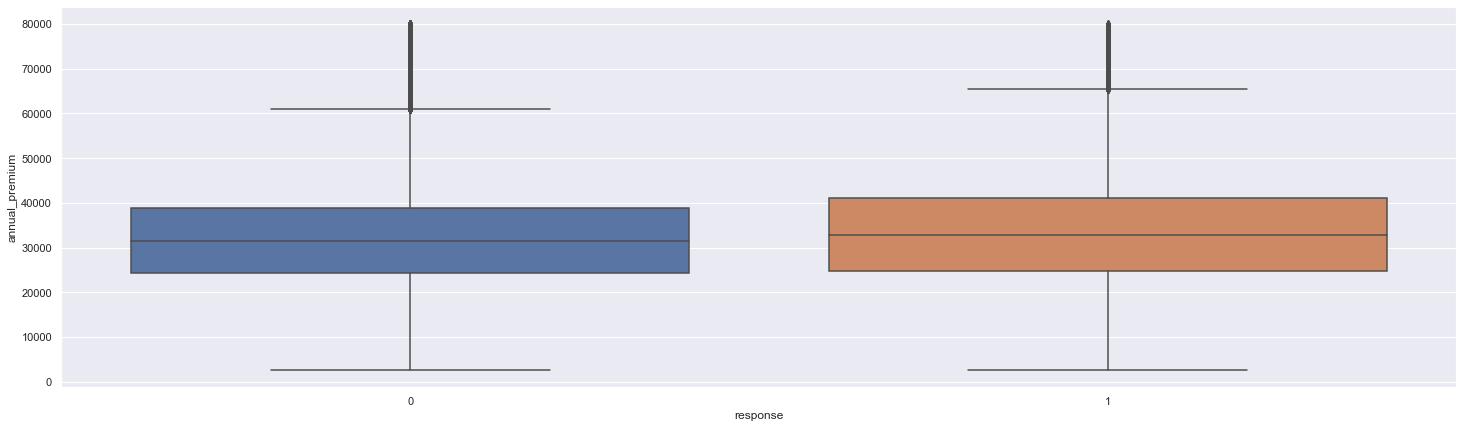

In [133]:
# annual_premium
aux = df6[df6['annual_premium'] < 80000]
sns.boxplot(x = 'response', y = 'annual_premium', data = aux);

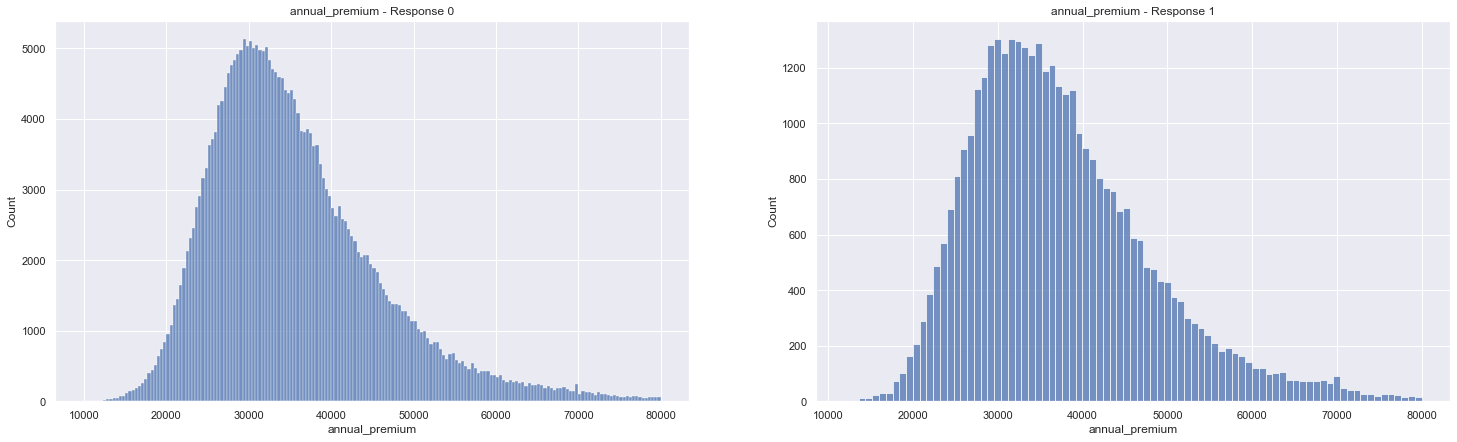

In [134]:
# annual_premium histogram
fig, axes = plt.subplots(1,2)

aux = df6[(df6['annual_premium'] > 10000) & (df6['annual_premium'] < 80000)]

aux1 = aux.loc[aux['response'] == 0, 'annual_premium']
aux2 = aux.loc[aux['response'] == 1, 'annual_premium']

sns.histplot(aux1, ax = axes.ravel()[0]);
sns.histplot(aux2, ax = axes.ravel()[1]);

axes.ravel()[0].set_title('annual_premium - Response 0');
axes.ravel()[1].set_title('annual_premium - Response 1');

### 6.2.3. Driving License<a id='driving_license'></a>

In [135]:
# driving_license
aux = df6[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux
# sns.barplot(x = 'response', y = 'driving_license', data = aux);

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


### 6.2.4. Region Code<a id='region_code'></a>

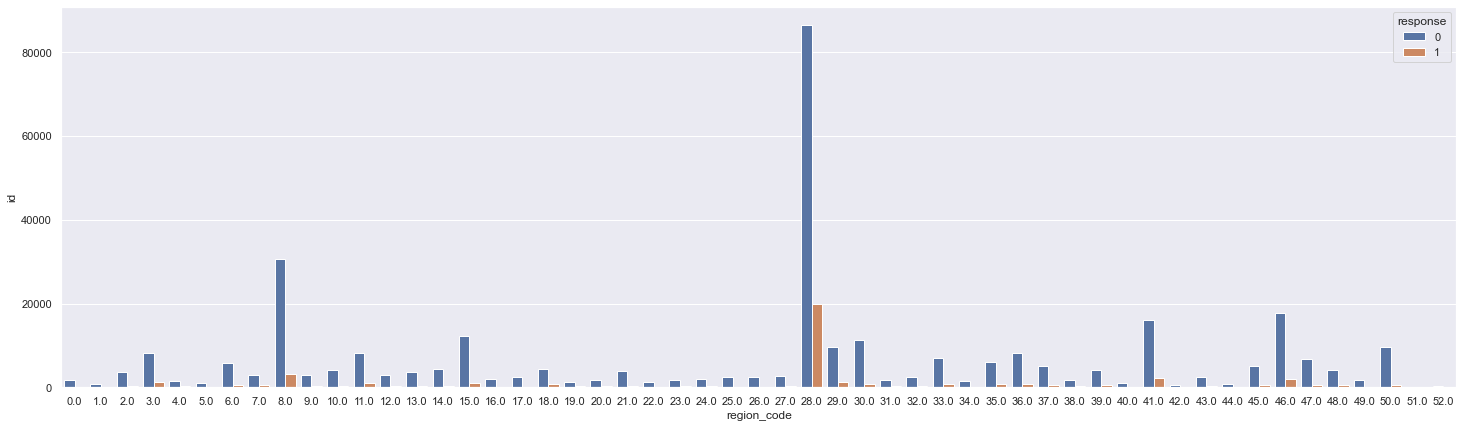

In [136]:
# region_code
aux = df6[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.barplot(x = 'region_code', y = 'id', hue = 'response', data = aux);

### 6.2.5. Previously Insured<a id='previously_insured'></a>

In [137]:
# previously_insured
pd.crosstab(df6['previously_insured'], df6['response']).apply(lambda x: x / x.sum(), axis = 1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### 6.2.6. Vehicle Age<a id='vehicle_age'></a>

In [138]:
# vehicle_age
df6[['vehicle_age', 'response']].value_counts(normalize = True).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


### 6.2.7. Policy Sales Channel<a id='policy_sales_channel'></a>

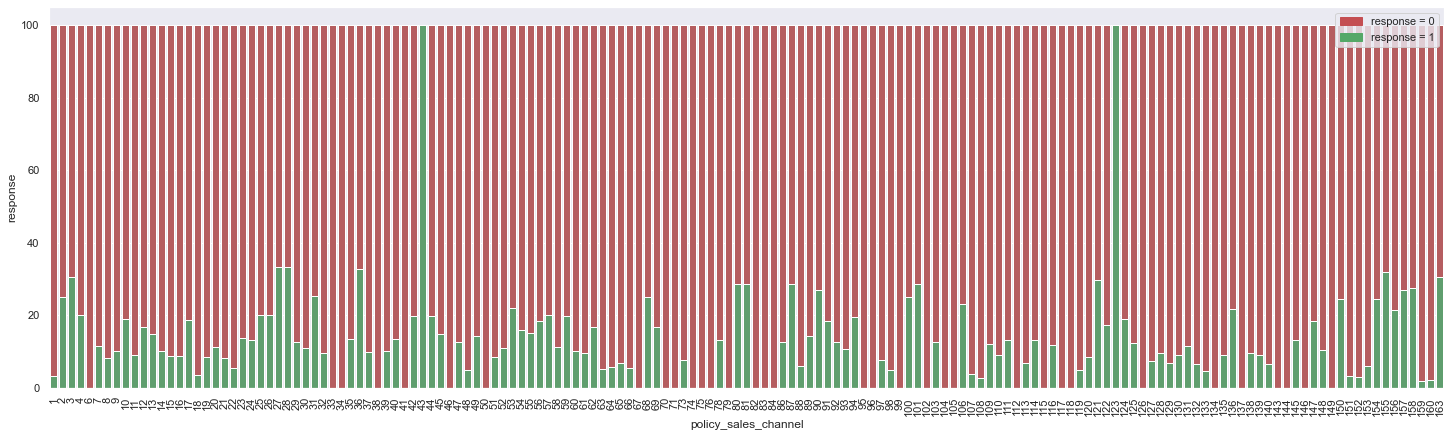

In [139]:
# from raw value to percentage
total = df6[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).count().reset_index()
response_yes = df6[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
response_yes['response'] = [i / j * 100 for i,j in zip(response_yes['response'], total['response'])]
total['response'] = [i / j * 100 for i,j in zip(total['response'], total['response'])]
total['policy_sales_channel'] = total['policy_sales_channel'].astype(int)
response_yes['policy_sales_channel'] = response_yes['policy_sales_channel'].astype(int)

# bar chart 1 -> top bars (group of 'response = 0')
bar1 = sns.barplot(x="policy_sales_channel",  y="response", data=total, color='r')

# bar chart 2 -> bottom bars (group of 'response = 1')
bar2 = sns.barplot(x="policy_sales_channel", y="response", data=response_yes, color='g')

# add legend
top_bar = mpatches.Patch(color='r', label='response = 0')
bottom_bar = mpatches.Patch(color='g', label='response = 1')
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.xticks(rotation = 90)
plt.show()

### 6.2.8. Vintage<a id='vintage'></a>

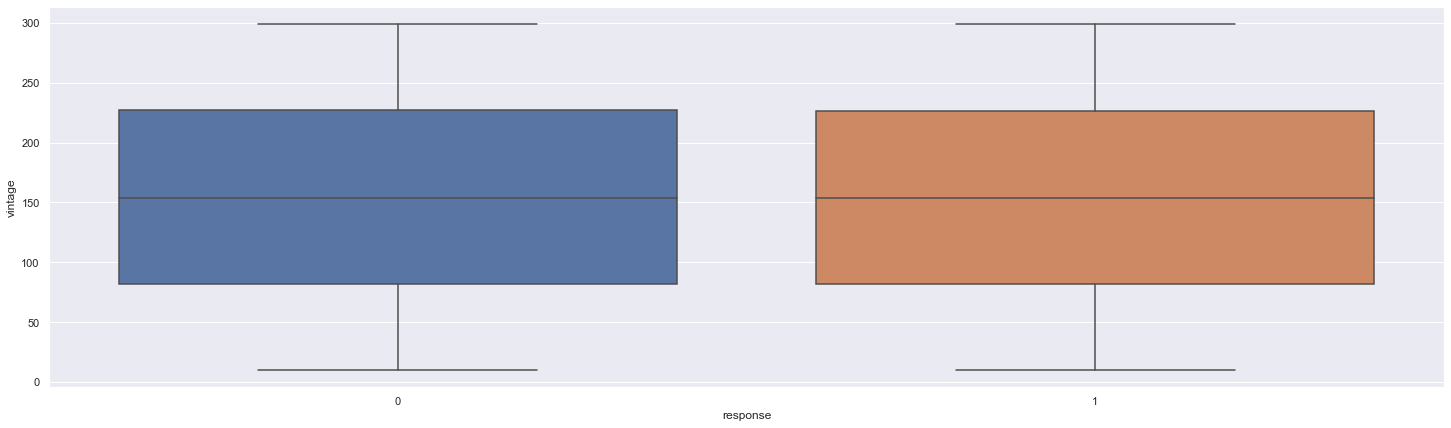

In [140]:
# vintage boxplot
sns.boxplot(x = 'response', y = 'vintage', data = df6);

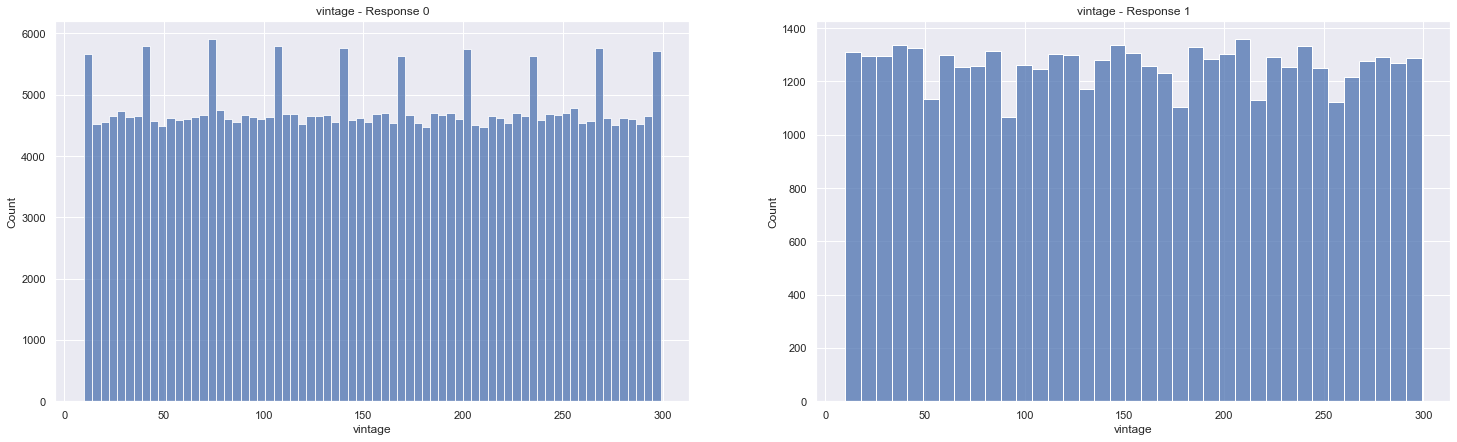

In [141]:
# vintage histogram
fig, axes = plt.subplots(1,2)

aux1 = df6.loc[df6['response'] == 0, 'vintage']
aux2 = df6.loc[df6['response'] == 1, 'vintage']

sns.histplot(aux1, ax = axes.ravel()[0]);
sns.histplot(aux2, ax = axes.ravel()[1]);

axes.ravel()[0].set_title('vintage - Response 0');
axes.ravel()[1].set_title('vintage - Response 1');

### 6.2.8. Gender<a id='gender'></a>

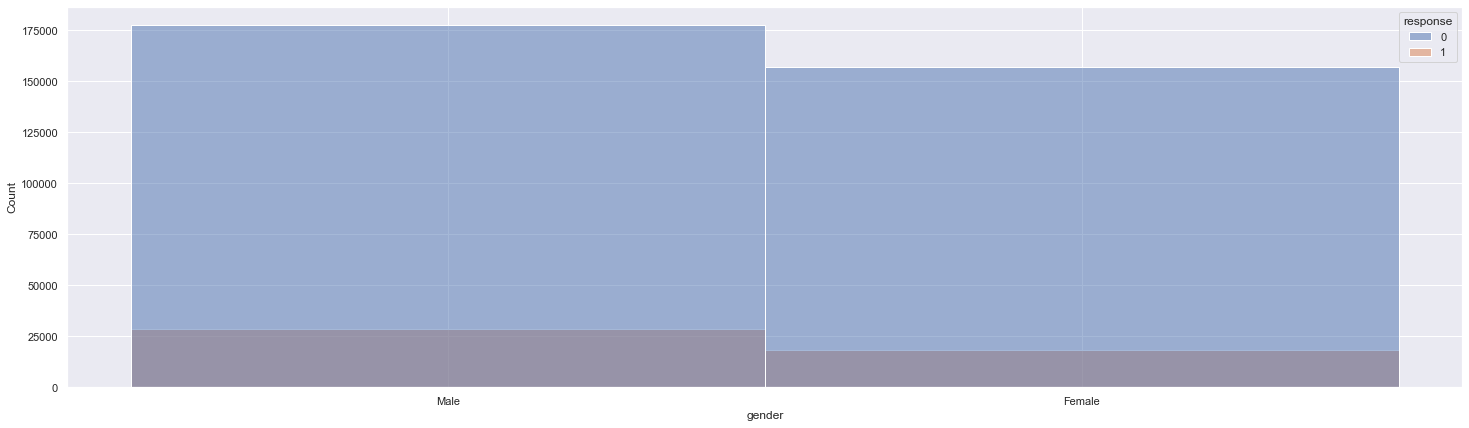

In [142]:
# gender
sns.histplot(x = 'gender', hue = 'response', data = df6);

In [143]:
# gender
df6[['gender', 'response']].value_counts(normalize = True).reset_index()

,gender,response,0
0,Male,0,0.465914
1,Female,0,0.411523
2,Male,1,0.074847
3,Female,1,0.047716


# 7. Data Preparation<a id='data_preparation'></a>

In [144]:
df7 = df6.copy()

## 7.1. Train-Test Split<a id='train_test_split'></a>

In [145]:
#predict variables
X = df7.drop(columns = ['response'], axis = 1)
#target variable
y = df7['response']

#Split data
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size = 0.2, random_state = 42)

## 7.2. Rescaling<a id='rescaling'></a>

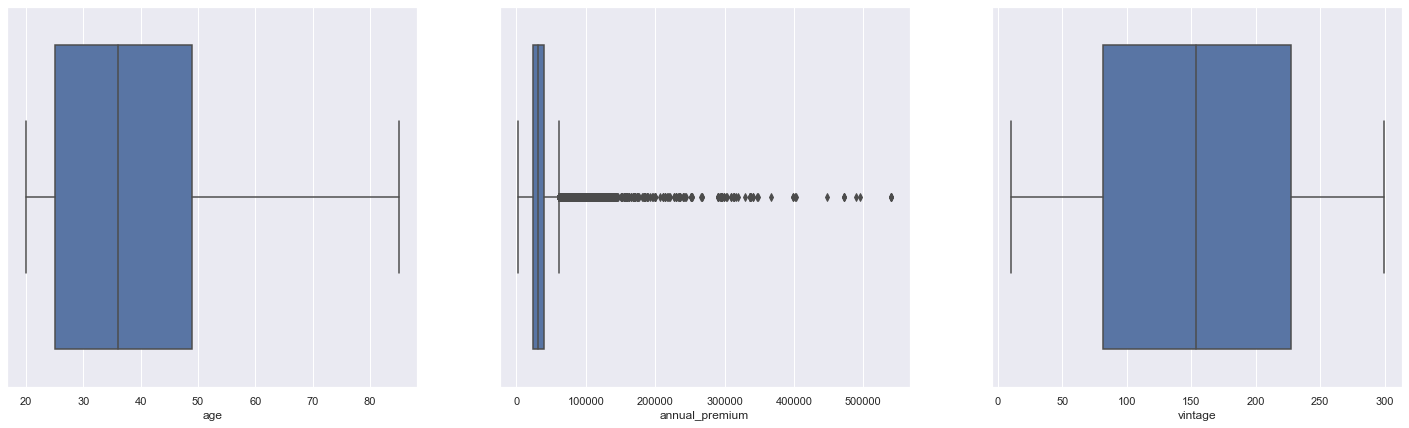

In [146]:
fig, axes = plt.subplots(1,3)

#age 
sns.boxplot(x ='age', data = X_train, ax = axes.ravel()[0])
#annual_premium
sns.boxplot(x = 'annual_premium', data = X_train, ax = axes.ravel()[1])
#vintage
sns.boxplot(x = 'vintage', data = X_train, ax = axes.ravel()[2])

plt.show()

In [147]:
#models
rs = RobustScaler()
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

#age
X_train['age'] = mms_age.fit_transform(X_train[['age']])
X_val['age'] = mms_age.transform(X_val[['age']])
with open("./scalers/age_scaler.pkl", "wb") as file:
    pickle.dump(mms_age, file)

#annual_premium
X_train['annual_premium'] = rs.fit_transform(X_train[['annual_premium']])
X_val['annual_premium'] = rs.transform(X_val[['annual_premium']])
with open("./scalers/annual_premium_scaler.pkl", "wb") as file:
    pickle.dump(rs, file)

#vintage
X_train['vintage'] = mms_vintage.fit_transform(X_train[['vintage']])
X_val['vintage'] = mms_vintage.transform(X_val[['vintage']])
with open("./scalers/vintage_scaler.pkl", "wb") as file:
    pickle.dump(mms_vintage, file)

## 7.3. Encoding<a id='encoding'></a>

In [148]:
#concat predict and target variables
df73 = pd.concat([X_train,y_train], axis = 1)

# gender
target_encode_gender  = df73.groupby('gender')['response'].mean()
df73.loc[:,'gender'] = df73['gender'].map(target_encode_gender)
with open("./scalers/target_encode_gender.pkl", "wb") as file:
    pickle.dump(target_encode_gender, file)

# region_code
target_encode_region_code  = df73.groupby("region_code")['response'].mean()
df73.loc[:,'region_code'] = df73['region_code'].map(target_encode_region_code)
with open("./scalers/target_encode_region_code.pkl", "wb") as file:
    pickle.dump(target_encode_region_code, file)

# policy_sales_channel
fe_policy_sales_channel  = df73.groupby("policy_sales_channel").size()/len(df73)
df73.loc[:,'policy_sales_channel'] = df73['policy_sales_channel'].map(fe_policy_sales_channel)
with open("./scalers/fe_policy_sales_channel.pkl", "wb") as file:
    pickle.dump(fe_policy_sales_channel, file)

# vehicle_age
df73 = pd.get_dummies(df73, prefix = 'vehicle_age', columns = ['vehicle_age'], drop_first = True)

#-------------------------------------------------------------- VALIDATION DATA ------------------------------------------------------------
df73_val = pd.concat([X_val,y_val], axis = 1).reset_index(drop = True)

# age
df73_val.loc[:,'age'] = mms_age.transform(df73_val[['age']])

# annual_premium
df73_val.loc[:,'annual_premium'] = rs.transform(df73_val[['annual_premium']])

# vintage
df73_val.loc[:,'vintage'] = mms_vintage.transform(df73_val[['vintage']])

# gender
df73_val.loc[:,'gender'] = df73_val['gender'].map(target_encode_gender)

# region_code
df73_val.loc[:,'region_code'] = df73_val['region_code'].map(target_encode_region_code)

# policy_sales_channel
df73_val.loc[:,'policy_sales_channel'] = df73_val['policy_sales_channel'].map(fe_policy_sales_channel)

# vehicle_age
df73_val = pd.get_dummies(df73_val, prefix = 'vehicle_age', columns = ['vehicle_age'], drop_first = True)

# 8. Feature Selection<a id='feature_selection'></a>

## 8.1. Extra Trees as Feature Selector<a id='extra_trees'></a>

In [149]:
# model definition
forest = ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df73.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                         feature  importance
0                        vintage    0.276374
1                 annual_premium    0.247232
2                            age    0.164175
3                    region_code    0.103678
4                 vehicle_damage    0.072815
5           policy_sales_channel    0.059212
6             previously_insured    0.055268
7   vehicle_age_between_1_2_year    0.011574
8                         gender    0.005013
9       vehicle_age_over_2_years    0.004181
10               driving_license    0.000478


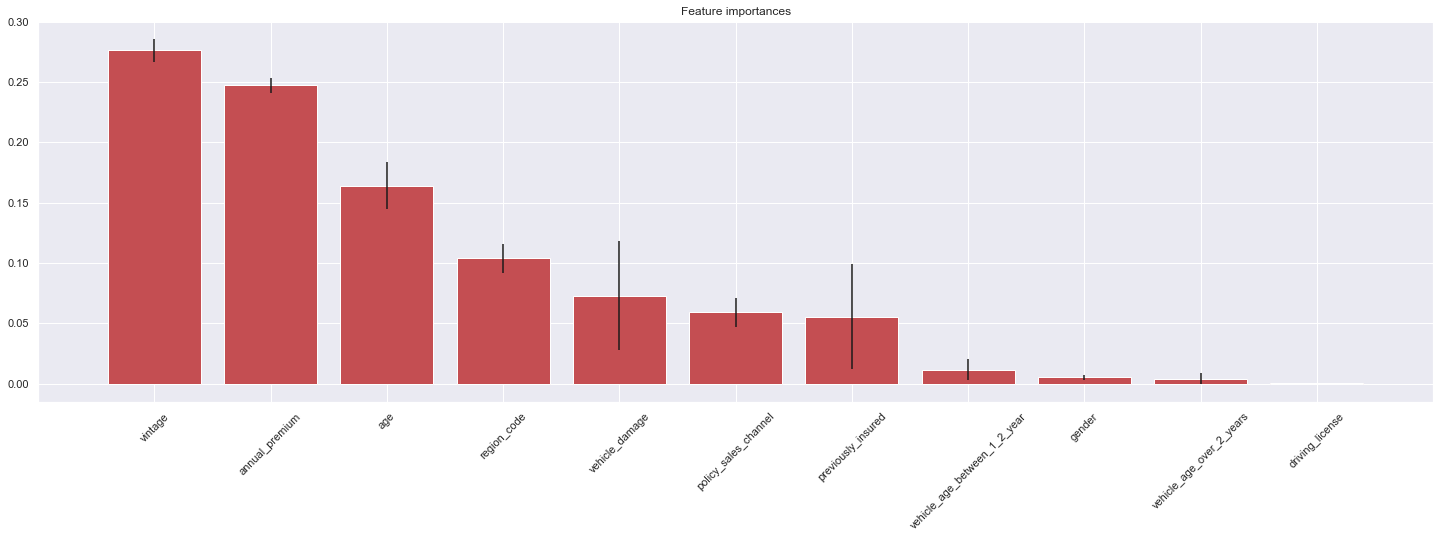

In [150]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ).reset_index(drop = True) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), df.iloc[indices, 0], rotation = 45)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 8.2. Manual Feature Selection<a id='manual_feature_selection'></a>

In [151]:
manual_feature_selection = ['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']

# predict features
X_train = df73[manual_feature_selection]
X_val = df73_val[manual_feature_selection]

# target features
y_train = df73['response']
y_val = df73_val['response']

In [152]:
X_train.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
332803,0.612457,1.690448,0.138462,0.061162,0,0.352554,1
116248,0.432526,-0.135558,0.061538,0.079791,0,0.352554,1
255005,0.311419,0.997535,0.200000,0.102644,0,0.209927,1
317474,0.401384,0.377365,0.015385,0.096875,1,0.352554,0
344212,0.235294,0.056555,0.046154,0.071809,1,0.209927,0


In [153]:
df73.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,response,vehicle_age_between_1_2_year,vehicle_age_over_2_years
332803,374686,0.138565,0.138462,0.061162,0.352554,1,0,1,1.690448,0.612457,0,0,0
116248,165999,0.138565,0.061538,0.079791,0.352554,1,0,1,-0.135558,0.432526,0,0,0
255005,132267,0.138565,0.200000,0.102644,0.209927,1,0,1,0.997535,0.311419,0,1,0
317474,250655,0.138565,0.015385,0.096875,0.352554,1,1,0,0.377365,0.401384,0,0,0
344212,85041,0.104297,0.046154,0.071809,0.209927,1,1,0,0.056555,0.235294,0,0,0


# 9. Machine Learning<a id='machine_learning'></a>

In [154]:
X_val['policy_sales_channel'].fillna(X_val['policy_sales_channel'].mean(), inplace = True)
X_train['policy_sales_channel'].fillna(X_train['policy_sales_channel'].mean(), inplace = True)

D:\Anaconda\envs\health\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


## 9.1. KNN<a id='knn'></a>

In [155]:
# model definition
knn_model = KNeighborsClassifier(n_neighbors=15)
with open("./models/model_knn.pkl", "wb") as file:
    pickle.dump(knn_model, file)

# model training
knn_model.fit(X_train, y_train)

# model prediction
yhat_knn = knn_model.predict_proba(X_val)

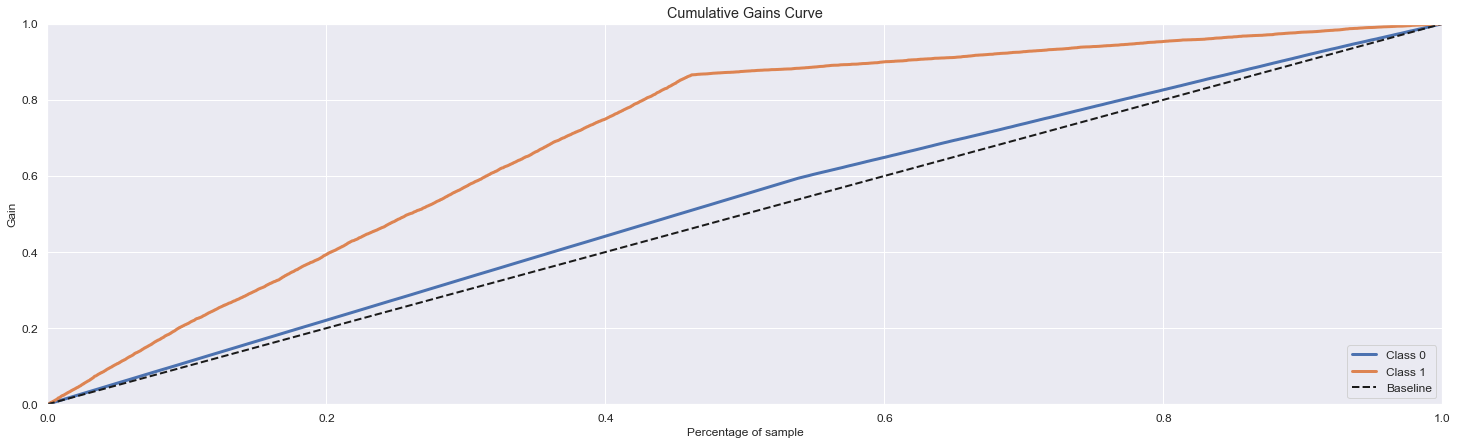

In [156]:
#Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn);

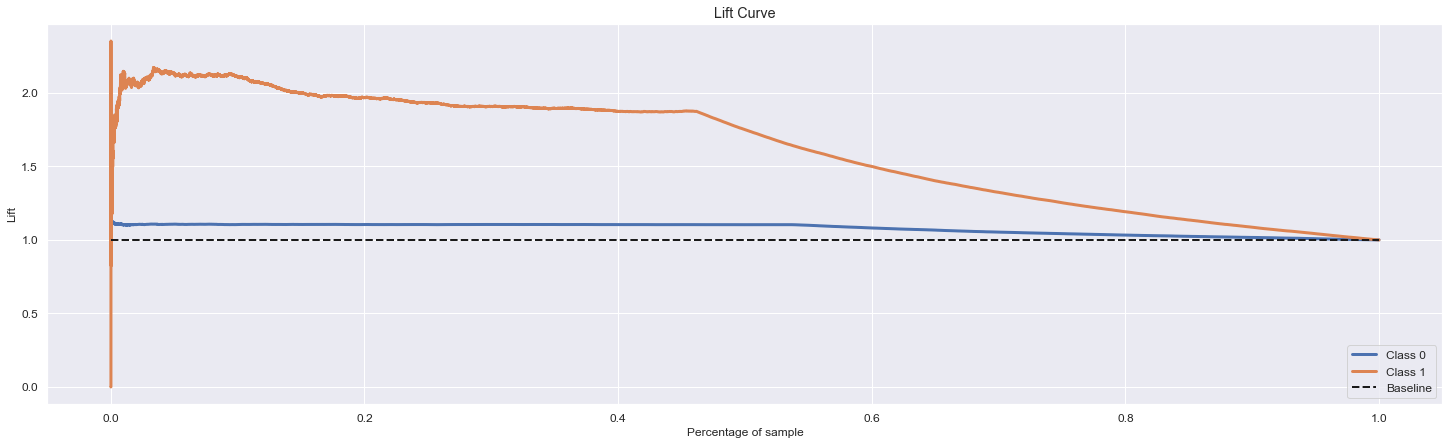

In [157]:
# Lift curve KNN
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

## 9.2. Logistic Regression<a id='logistic_regression'></a>

In [158]:
#model
lr = LogisticRegression(random_state = 42)
with open("./models/model_logistic_regression.pkl", "wb") as file:
    pickle.dump(lr, file)

#fit model
lr.fit(X_train,y_train)

#predict model
yhat_lr = lr.predict_proba(X_val)

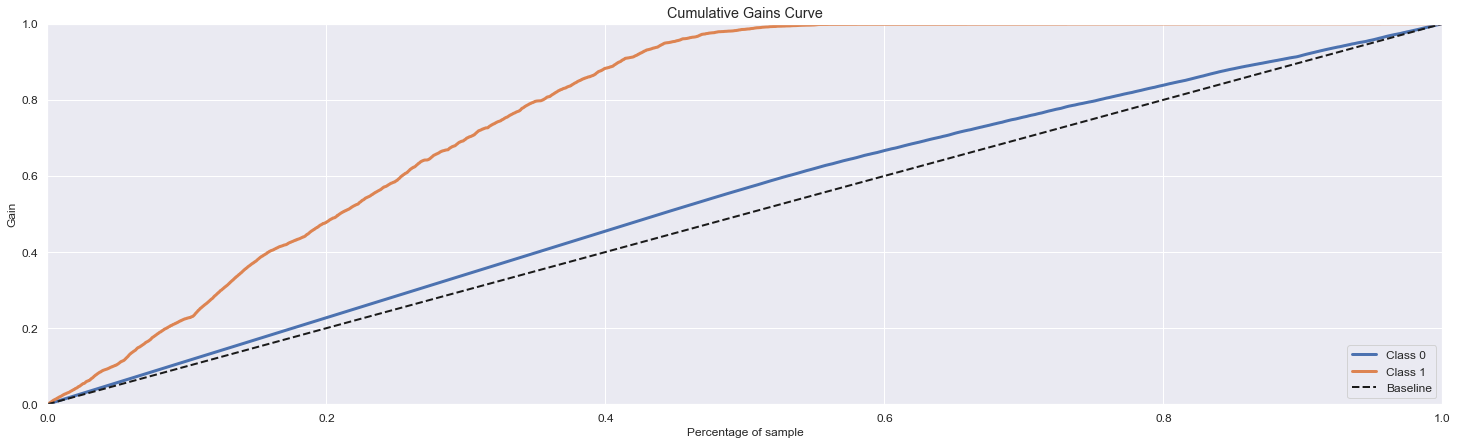

In [159]:
## Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr ); 

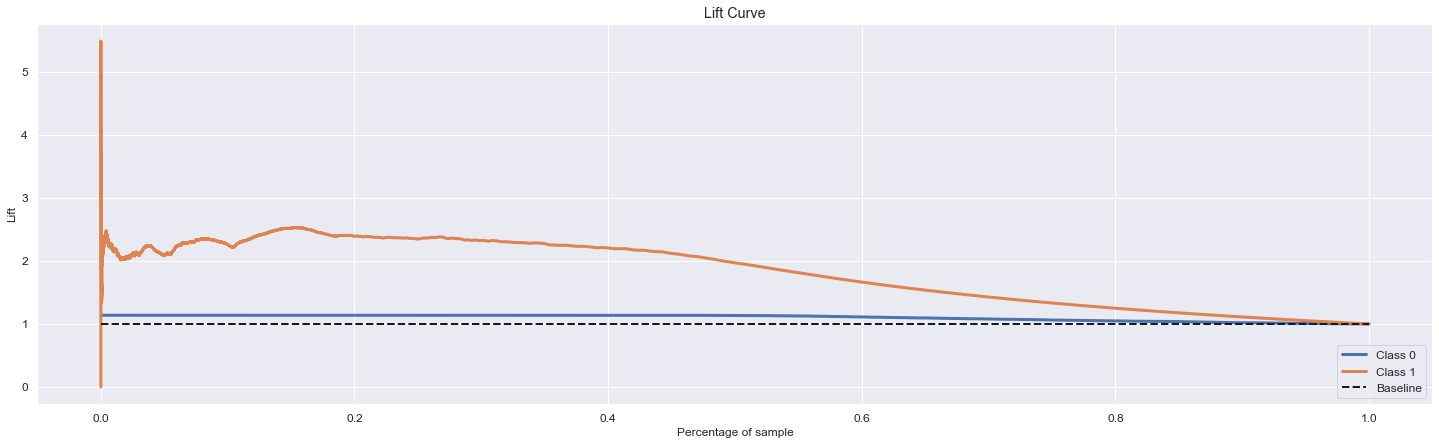

In [160]:
# Lift curve Logistic Regression
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

## 9.3. Random Forest Classifier<a id='random_forest'></a>

In [161]:
#model
rf = RandomForestClassifier(n_jobs = -1)
with open("./models/model_rf.pkl", "wb") as file:
    pickle.dump(rf, file)

#fit model
rf.fit(X_train,y_train)

#predict proba
yhat_rf = rf.predict_proba(X_val)

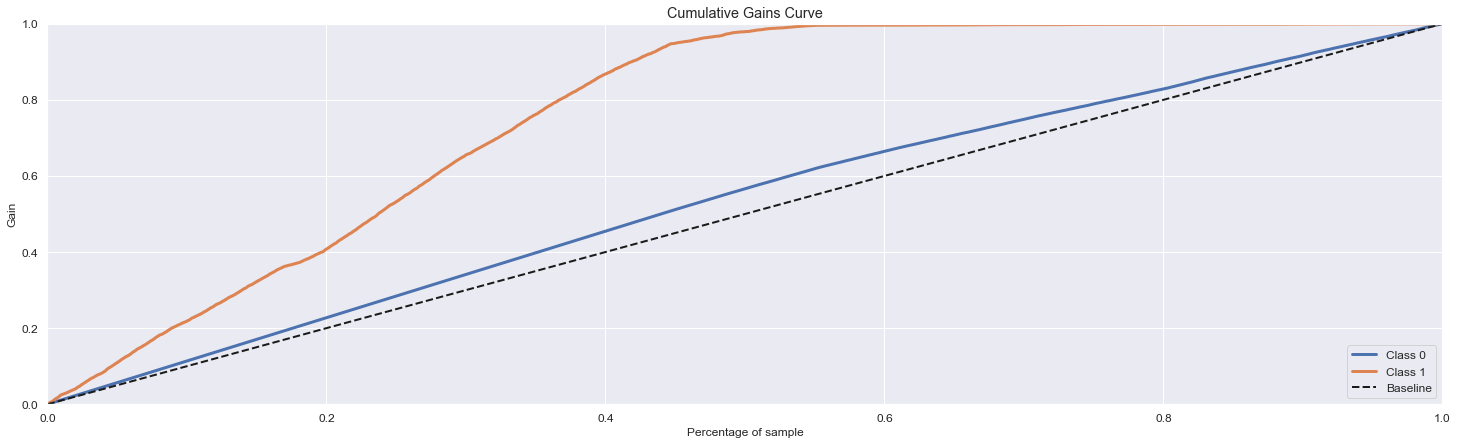

In [162]:
## Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf ); 

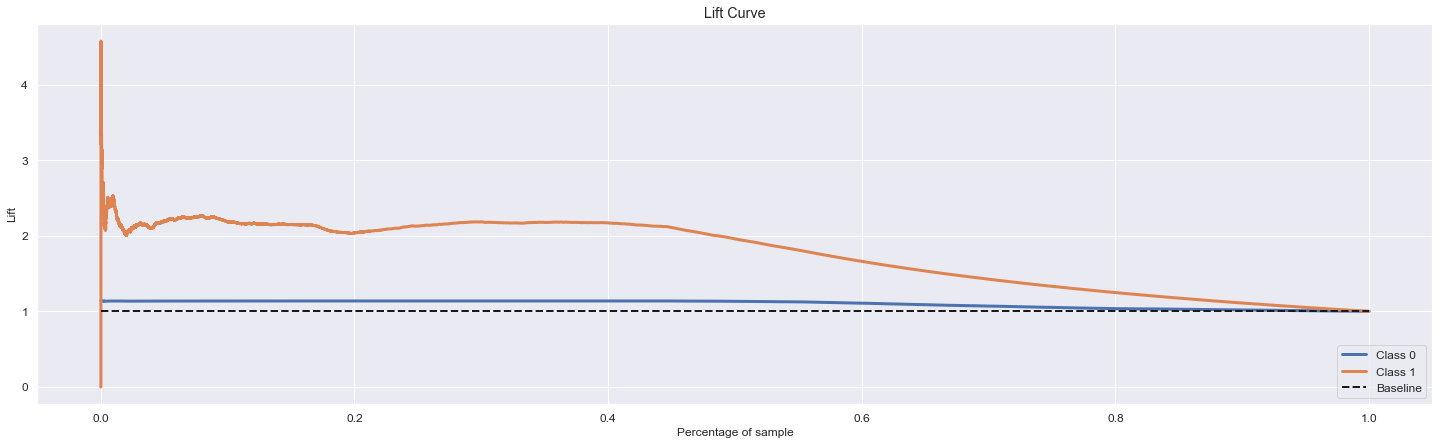

In [163]:
# Lift curve Random Forest
skplt.metrics.plot_lift_curve( y_val, yhat_rf );

## 9.4. Extra Trees Classifier<a id='extra_trees'></a>

In [164]:
# model definition
et = ExtraTreesClassifier(n_jobs=-1) 
with open("./models/model_et.pkl", "wb") as file:
    pickle.dump(et, file)

# model training
et.fit(X_train, y_train)

# model prediction
yhat_et = et.predict_proba(X_val)

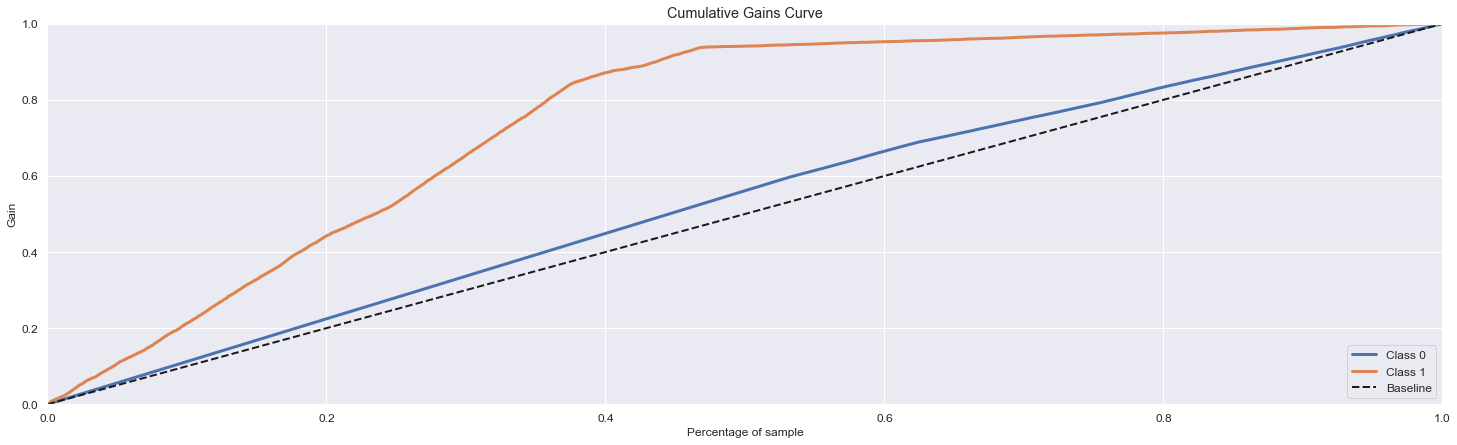

In [165]:
#Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_et);

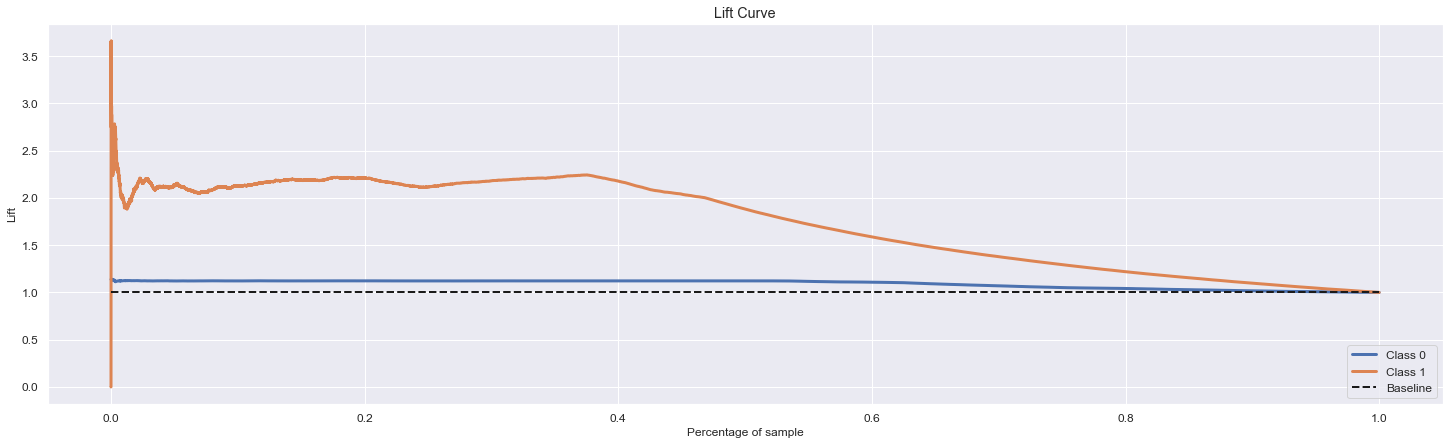

In [166]:
# Lift curve Extra Trees
skplt.metrics.plot_lift_curve( y_val, yhat_et );

# 10. Model Performance<a id='model_performance'></a>

In [167]:
def precision_at_k( data, k=10 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return ( data.loc[ k, 'precision_at_k'], data )

def recall_at_k( data, k=15 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'], data )

In [173]:
#copy data
df10 = df73_val.copy()

#score customers
df10['score'] = yhat_et[:,1].tolist()

#sort values
df10 = df10.sort_values("score", ascending = False)

# compute precision at k 
precision_at_50, data = precision_at_k( df10, k=50 )

# compute recall at k
recall_at_50, data = recall_at_k( df10, k=50 )

In [175]:
recall_at_50

0.002052722558340536